# Merging Climate Datasets Exercise

Work through this notebook to practice harmonizing and merging two climate datasets that differ in temporal cadence and spatial resolution.

You will: 
- Load two public NOAA datasets directly from the cloud
- Subset to the continental US (use 230°E–300°E in longitude since the data span 0–360°)
- Use `xr.resample` to aggregate time and `xr.interp` to match grids
- Combine the variables with `xr.merge` for joint analysis

Refer back to the answer key after attempting each step.


## 1. Setup


In [119]:
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
except ImportError:
    ccrs = None
    cfeature = None

TEMP_URL = "https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.2020.nc"
PRECIP_URL = "https://psl.noaa.gov/thredds/dodsC/Datasets/cpc_global_precip/precip.2020.nc"

LAT_RANGE = (20, 50)  # degrees North
LON_RANGE_360 = (230, 300)  # degrees East (equivalent to -130° to -60°)
LON_RANGE_180 = (-130, -60)  # convenience if a dataset uses -180° to 180°

TIME_RANGE = slice("2020-06-01", "2020-06-30")


## 2. Load the datasets

Open both remote datasets with `xr.open_dataset`, passing a reasonable chunk size for the time dimension. Assign the resulting objects to `air` and `precip`.


In [ ]:
# TODO: load the air temperature and precipitation datasets.
# Example: air = xr.open_dataset(..., chunks={"time": 8})
#raise NotImplementedError("Assign datasets to `air` and `precip`.")
ds_air = xr.load_dataset(TEMP_URL,chunks={"time":24})
ds_precip = xr.load_dataset(PRECIP_URL,chunks={"time":8})


In [60]:
ds_air

<xarray.Dataset> Size: 62MB
Dimensions:  (time: 1464, lat: 73, lon: 144)
Coordinates:
  * lat      (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 12kB 2020-01-01 ... 2020-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 62MB 243.0 243.0 243.0 ... 251.0 251.0
Attributes:
    Conventions:                     COARDS
    title:                           4x daily NMC reanalysis (2014)
    history:                         created 2017/12 by Hoop (netCDF2.3)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimension:  time

In [ ]:
ds_precip['precip

<xarray.Dataset> Size: 379MB
Dimensions:  (time: 366, lat: 360, lon: 720)
Coordinates:
  * lat      (lat) float32 1kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 3kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * time     (time) datetime64[ns] 3kB 2020-01-01 2020-01-02 ... 2020-12-31
Data variables:
    precip   (time, lat, lon) float32 379MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    _NCProperties:                   version=1|netcdflibversion=4.4.1.1|hdf5l...
    Conventions:                     CF-1.0
    version:                         V1.0
    title:                           CPC GLOBAL PRCP V1.0 RT
    dataset_title:                   CPC GLOBAL PRCP V1.0
    Source:                          ftp://ftp.cpc.ncep.noaa.gov/precip/CPC_U...
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    history:                         Updated 2021-01-02 23:31:03
    DODS_EXTRA.Unlimited_Dimension:  time

## 3. Subset to the continental United States and June 2020

Select the bounding box provided above and limit the time range to June 2020 for both datasets. Store the results in `air_us` and `precip_us`.
Remember that longitude runs from 0° to 360°, so select 230°E–300°E. Check whether each coordinate is ascending or descending before building the slice.


In [76]:
# TODO: subset both datasets using `sel`, handling coordinate ordering as needed.
#raise NotImplementedError("Create `air_us` and `precip_us`.")
air_us = ds_air.sel(lat=slice(50,20),lon=slice(230, 300),time=slice("2020-06-01", "2020-06-30"))
precip_us = ds_precip.sel(lat=slice(50,20),lon=slice(230, 300),time=slice("2020-06-01", "2020-06-30"))


In [77]:
precip_us

<xarray.Dataset> Size: 1MB
Dimensions:  (time: 30, lat: 60, lon: 140)
Coordinates:
  * lat      (lat) float32 240B 49.75 49.25 48.75 48.25 ... 21.25 20.75 20.25
  * lon      (lon) float32 560B 230.2 230.8 231.2 231.8 ... 298.8 299.2 299.8
  * time     (time) datetime64[ns] 240B 2020-06-01 2020-06-02 ... 2020-06-30
Data variables:
    precip   (time, lat, lon) float32 1MB nan nan nan nan ... nan nan nan nan
Attributes:
    _NCProperties:                   version=1|netcdflibversion=4.4.1.1|hdf5l...
    Conventions:                     CF-1.0
    version:                         V1.0
    title:                           CPC GLOBAL PRCP V1.0 RT
    dataset_title:                   CPC GLOBAL PRCP V1.0
    Source:                          ftp://ftp.cpc.ncep.noaa.gov/precip/CPC_U...
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    history:                         Updated 2021-01-02 23:31:03
    DODS_EXTRA.Unlimited_Dimension:  time

In [78]:
air_us

<xarray.Dataset> Size: 182kB
Dimensions:  (time: 120, lat: 13, lon: 29)
Coordinates:
  * lat      (lat) float32 52B 50.0 47.5 45.0 42.5 40.0 ... 27.5 25.0 22.5 20.0
  * lon      (lon) float32 116B 230.0 232.5 235.0 237.5 ... 295.0 297.5 300.0
  * time     (time) datetime64[ns] 960B 2020-06-01 ... 2020-06-30T18:00:00
Data variables:
    air      (time, lat, lon) float32 181kB 283.3 282.3 280.8 ... 302.3 302.2
Attributes:
    Conventions:                     COARDS
    title:                           4x daily NMC reanalysis (2014)
    history:                         created 2017/12 by Hoop (netCDF2.3)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimension:  time

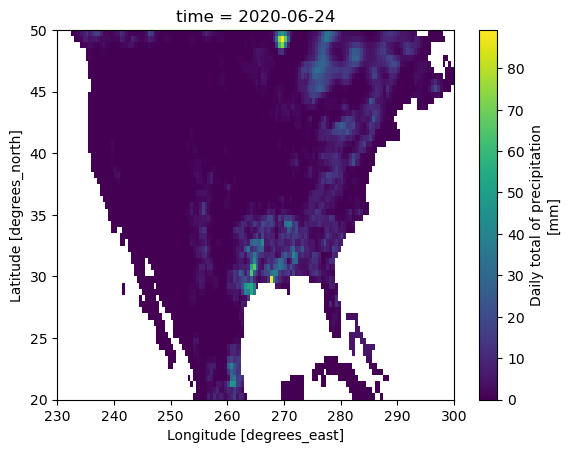

In [81]:
precip_us['precip'].isel(time=23).plot()

In [45]:
air_us['air'].max()

<xarray.DataArray 'air' ()> Size: 4B
array(316.2, dtype=float32)

## 4. Align temporal cadence

Aggregate the six-hourly air temperatures to daily means with `xr.resample`. Name the resulting DataArray `air_daily`.


In [84]:
### TODO: use xr.resample to create daily means.
#raise NotImplementedError("Create `air_daily`.")
air_daily = air_us.resample(time='D').mean()


In [85]:
air_daily

<xarray.Dataset> Size: 46kB
Dimensions:  (time: 30, lat: 13, lon: 29)
Coordinates:
  * lat      (lat) float32 52B 50.0 47.5 45.0 42.5 40.0 ... 27.5 25.0 22.5 20.0
  * lon      (lon) float32 116B 230.0 232.5 235.0 237.5 ... 295.0 297.5 300.0
  * time     (time) datetime64[ns] 240B 2020-06-01 2020-06-02 ... 2020-06-30
Data variables:
    air      (time, lat, lon) float32 45kB 283.7 282.0 279.7 ... 301.1 300.9
Attributes:
    Conventions:                     COARDS
    title:                           4x daily NMC reanalysis (2014)
    history:                         created 2017/12 by Hoop (netCDF2.3)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimension:  time

## 5. Interpolate to the precipitation grid

Use `xr.interp` to interpolate the daily air temperatures onto the precipitation grid (`precip_us.lat` and `precip_us.lon`). Store the interpolated result in `air_interp`.


In [ ]:
# TODO: interpolate the resampled temperature field onto the precipitation grid.
#raise NotImplementedError("Create `air_interp`.")
air_interp = air_daily.interp(lat=precip_us["lat"], lon=precip_us["lon"])
air_interp


<xarray.Dataset> Size: 1MB
Dimensions:  (time: 30, lat: 60, lon: 140)
Coordinates:
  * time     (time) datetime64[ns] 240B 2020-06-01 2020-06-02 ... 2020-06-30
  * lat      (lat) float32 240B 49.75 49.25 48.75 48.25 ... 21.25 20.75 20.25
  * lon      (lon) float32 560B 230.2 230.8 231.2 231.8 ... 298.8 299.2 299.8
Data variables:
    air      (time, lat, lon) float32 1MB 283.7 283.4 283.1 ... 301.0 300.9
Attributes:
    Conventions:                     COARDS
    title:                           4x daily NMC reanalysis (2014)
    history:                         created 2017/12 by Hoop (netCDF2.3)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimension:  time

## 6. Merge the datasets

Convert the aligned arrays into datasets with clear variable names and merge them with `xr.merge`. Save the output as `merged`.


In [189]:
# TODO: build datasets and merge them into one object named `merged`.
# raise NotImplementedError("Create `merged`.")
merged = xr.merge([air_interp,precip_us]).copy()
merged = merged.rename_vars({"air": "air_temperature", "precip": "daily_precip"})
merged.attrs['title'] = "daily temperature mean and daily precipitation"
merged.air_temperature.attrs['long_name'] = "Mean Daily Air temperature at sigma level 995"
merged


<xarray.Dataset> Size: 2MB
Dimensions:          (time: 30, lat: 60, lon: 140)
Coordinates:
  * time             (time) datetime64[ns] 240B 2020-06-01 ... 2020-06-30
  * lat              (lat) float32 240B 49.75 49.25 48.75 ... 21.25 20.75 20.25
  * lon              (lon) float32 560B 230.2 230.8 231.2 ... 298.8 299.2 299.8
Data variables:
    air_temperature  (time, lat, lon) float32 1MB 283.7 283.4 ... 301.0 300.9
    daily_precip     (time, lat, lon) float32 1MB nan nan nan ... nan nan nan
Attributes:
    Conventions:                     COARDS
    title:                           daily temperature mean and daily precipi...
    history:                         created 2017/12 by Hoop (netCDF2.3)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimension:  time

## 7. Inspect your result

Once your pipeline runs without `NotImplementedError`, evaluate the following cell to sanity-check the merged dataset.


In [105]:
# The assertions below should pass once you have completed the exercise.
assert set(merged.data_vars) == {"air_temperature", "daily_precip"}
assert merged.air_temperature.dims == merged.daily_precip.dims
print(merged)


<xarray.Dataset> Size: 2MB
Dimensions:          (time: 30, lat: 60, lon: 140)
Coordinates:
  * time             (time) datetime64[ns] 240B 2020-06-01 ... 2020-06-30
  * lat              (lat) float32 240B 49.75 49.25 48.75 ... 21.25 20.75 20.25
  * lon              (lon) float32 560B 230.2 230.8 231.2 ... 298.8 299.2 299.8
Data variables:
    air_temperature  (time, lat, lon) float32 1MB 283.7 283.4 ... 301.0 300.9
    daily_precip     (time, lat, lon) float32 1MB nan nan nan ... nan nan nan
Attributes:
    Conventions:                     COARDS
    title:                           4x daily NMC reanalysis (2014)
    history:                         created 2017/12 by Hoop (netCDF2.3)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    References:                      http://www.ps

In [122]:
merged['air_temperature']

<xarray.DataArray 'air_temperature' (time: 30, lat: 60, lon: 140)> Size: 1MB
array([[[283.65726, 283.36176, 283.06625, ..., 283.2475 , 283.56653,
         283.8855 ],
        [283.95673, 283.74023, 283.52374, ..., 282.9425 , 283.1795 ,
         283.4165 ],
        [284.25623, 284.11874, 283.98126, ..., 282.6375 , 282.7925 ,
         282.9475 ],
        ...,
        [293.21124, 293.08374, 292.95624, ..., 300.375  , 300.235  ,
         300.095  ],
        [293.31375, 293.19125, 293.06873, ..., 300.365  , 300.237  ,
         300.10898],
        [293.41626, 293.29874, 293.18124, ..., 300.35498, 300.23898,
         300.123  ]],

       [[284.3532 , 283.92474, 283.49622, ..., 282.2025 , 282.5195 ,
         282.8365 ],
        [284.62973, 284.28424, 283.93872, ..., 281.8075 , 282.0585 ,
         282.3095 ],
        [284.90622, 284.64374, 284.38123, ..., 281.41248, 281.5975 ,
         281.7825 ],
...
        [293.23248, 293.0975 , 292.9625 , ..., 300.9125 , 300.79752,
         300.6825 ],
        [293.5195 , 293.3985 , 293.2775 , ..., 300.8925 , 300.7815 ,
         300.6705 ],
        [293.8065 , 293.6995 , 293.5925 , ..., 300.8725 , 300.7655 ,
         300.65848]],

       [[285.181  , 285.003  , 284.82498, ..., 290.26495, 290.39697,
         290.52896],
        [285.30298, 285.189  , 285.07498, ..., 289.81998, 289.90598,
         289.99197],
        [285.425  , 285.37497, 285.32498, ..., 289.37497, 289.41498,
         289.455  ],
        ...,
        [292.82373, 292.74625, 292.66873, ..., 300.94373, 300.88623,
         300.82874],
        [293.15424, 293.08774, 293.02124, ..., 300.97125, 300.92673,
         300.88223],
        [293.48474, 293.42923, 293.37372, ..., 300.99875, 300.96725,
         300.93573]]], shape=(30, 60, 140), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 240B 2020-06-01 2020-06-02 ... 2020-06-30
  * lat      (lat) float32 240B 49.75 49.25 48.75 48.25 ... 21.25 20.75 20.25
  * lon      (lon) float32 560B 230.2 230.8 231.2 231.8 ... 298.8 299.2 299.8
Attributes: (12/13)
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    ...            ...
    parent_stat:   Other
    valid_range:   [185.16 331.16]
    dataset:       NCEP Reanalysis
    actual_range:  [188.6 324.1]
    level_desc:    0.995 sigma
    _ChunkSizes:   [  1  73 144]

## 8. Check In

- Render both variables at the first timestep on a `cartopy` map to verify alignment visually (PlateCarree works well).
- Build a scatter plot comparing colocated temperature and precipitation values across the merged domain.
- Save the merged output with `to_netcdf` for future analysis.


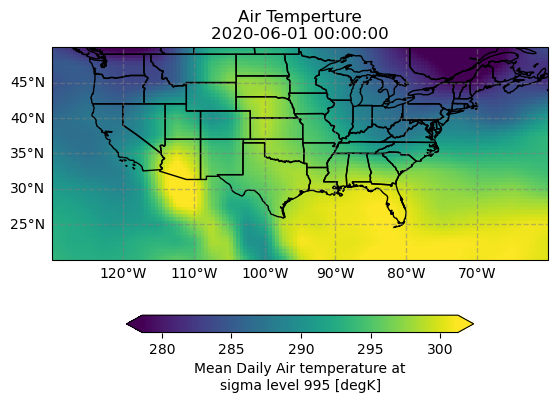

In [131]:
import cartopy.crs as ccrs
import cartopy.feature as cfeaturet
var = 'air_temperature'
fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()))
merged[var].isel(time=0).plot(  ax=axis,
    transform=ccrs.PlateCarree(),  # this is important!
    # usual xarray stuff
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.7},
    robust=True,)
plt.title('Air Temperture\n{}'.format(pd.to_datetime(merged['time'].isel(time=0).values)))
#axis.coastlines()
axis.add_feature(cfeature.STATES, edgecolor='black')
#               [x_min, x_max, y_min, y_max] 
gl = axis.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False  # Hide labels on the top
gl.right_labels = False # Hide labels on the right

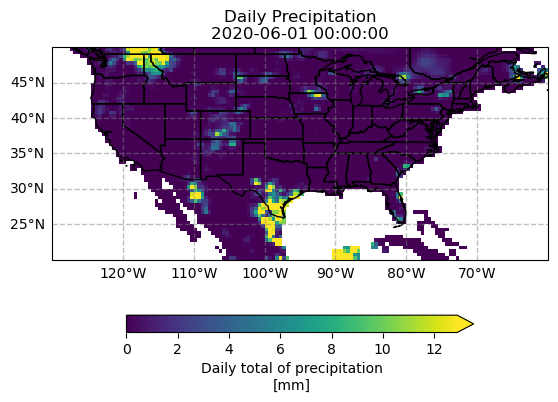

In [133]:
var = 'daily_precip'
fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()))
merged[var].isel(time=0).plot(  ax=axis,
    transform=ccrs.PlateCarree(),  # this is important!
    # usual xarray stuff
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.7},
    robust=True,)
plt.title('Daily Precipitation\n{}'.format(pd.to_datetime(merged['time'].isel(time=0).values)))
#axis.coastlines()
axis.add_feature(cfeature.STATES, edgecolor='black')
#               [x_min, x_max, y_min, y_max] 
gl = axis.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False  # Hide labels on the top
gl.right_labels = False # Hide labels on the right

Text(0, 0.5, 'Precipitation (mm)')

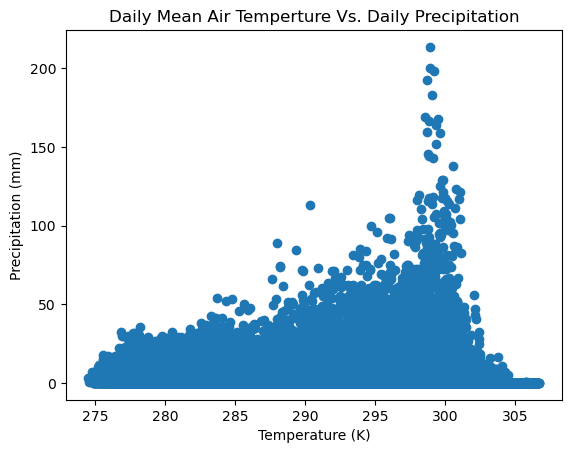

In [147]:
plt.scatter(merged.air_temperature.values,merged.daily_precip.values)
plt.title('Daily Mean Air Temperture Vs. Daily Precipitation')
plt.xlabel('Temperature (K)')
plt.ylabel('Precipitation (mm)')

In [192]:
merged.attrs.pop('_NCProperties', None)
merged.to_netcdf('/home/pat6/module_3/ATMS-523-Module-3-Checkin-trierweiler/merged.nc')